In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

# DataFrame 생성
src = './data/cat_dog_tfrecord'

df = pd.DataFrame(os.listdir(src),
                  columns=['filename'])

display(df.head())

,filename
0,dog.1097.jpg
1,cat.1588.jpg
2,dog.1953.jpg
3,cat.672.jpg
4,dog.1355.jpg


In [27]:
df['label'] = ~df['filename'].str.contains('cat')
df = df.astype({'label':'int'})
df['filename'] = df['filename'].map(lambda x : src + '/' + x)
display(df.head())

,filename,label
0,./data/cat_dog_tfrecord/dog.1097.jpg,1
1,./data/cat_dog_tfrecord/cat.1588.jpg,0
2,./data/cat_dog_tfrecord/dog.1953.jpg,1
3,./data/cat_dog_tfrecord/cat.672.jpg,0
4,./data/cat_dog_tfrecord/dog.1355.jpg,1


In [28]:
# 데이터 분리 및 TFRecord 생성

x_data_train, x_data_val, t_data_train, t_data_val = \
train_test_split(df['filename'],
                 df['label'],
                 test_size=0.2,
                 stratify=df['label'])

# 가지고 있는 이미지 데이터를 TFrecord로 변환
# 이 TFRecord를 읽어들여서 tf.data.Dataset으로 만들고
# 이 Dataset을 모델의 입력으로 넣어서 최적의 입력형태를 만들어서 사용!
# TFRecord는 파일의 내용을 변형시키지 않고 저장하는게 일반적
# 실제 학습에 필요한 형태로 변환시키는 작업은 Dataset에서 실행

# filename_list : 이미지 파일명을 가지고 있는 Series
# label_list : 이미지 파일의 label을 가지고 있는 Series
# tfrecords_name : TFRecord 이름
def to_tfrecords(filename_list, label_list, tfrecords_name):
    print('파일 생성 시작')
    tf_filename = os.path.join(tfrecords_name + '.tfrecords')
    with tf.io.TFRecordWriter(path=tf_filename) as writer:
        for filename_, label_ in tqdm(zip(filename_list, label_list),
                                      total=len(filename_list),
                                      position=0,
                                      leave=True):
            _binary_image = tf.io.read_file(filename_).numpy()
            feature = {
                'image_raw' : tf.train.Feature(bytes_list=tf.train.BytesList(value=[_binary_image])),
                'label' : tf.train.Feature(int64_list=tf.train.Int64List(value=[label_]))
            }            
            features = tf.train.Features(feature=feature)
            example = tf.train.Example(features=features)

            writer.write(example.SerializeToString())

to_tfrecords(x_data_train, t_data_train, './cat_dog_train')
to_tfrecords(x_data_val, t_data_val, './cat_dog_val')    

파일 생성 시작


  0%|          | 0/3200 [00:00<?, ?it/s]

파일 생성 시작


  0%|          | 0/800 [00:00<?, ?it/s]

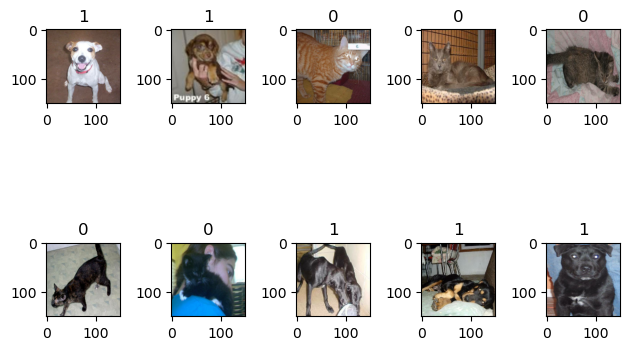

In [36]:
# TFRecord에 이미지가 잘 저장되었는지 확인해보아요!
# tf.data.Dataset을 이용해서 처리해야 해요!
train_tfrecord_path = './cat_dog_train.tfrecords'

BUFFER_SIZE = 1000 # shuffle 때문에 설정
BATCH_SIZE = 32 # 배치 크기
IMAGE_SIZE = 150 # 이미지 크기

# TFRecord를 읽으려면 feature description을 작성해야 해요!
feature_description = {
    'image_raw' : tf.io.FixedLenFeature([], tf.string),
    'label' : tf.io.FixedLenFeature([], tf.int64)
}

# TFRecord 안에 있는 각각의 Example 객체를 읽어들여서 복원
def _parse_image_function(proto):
    return tf.io.parse_single_example(proto, feature_description)

def get_img_tensor(target_record):
    img = target_record['image_raw']
    label = target_record['label']
    img = tf.image.decode_jpeg(img, channels=3)

    return img, label

def image_preprocessing(img, label):
    result_image = img / 255
    result_image = tf.image.resize(result_image, 
                                   (IMAGE_SIZE, IMAGE_SIZE), 
                                   antialias=False)
    return result_image, label

# tf.data.Dataset을 생성해야 해요!
dataset = tf.data.TFRecordDataset(train_tfrecord_path)

dataset = dataset.map(_parse_image_function,
                      num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.map(get_img_tensor,
                      num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.map(image_preprocessing,
                      num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache() # 속도 증가
dataset = dataset.shuffle(BUFFER_SIZE) # 학습의 효율을 높이기 위해서
dataset = dataset.batch(BATCH_SIZE) # 속도 증가
dataset = dataset.prefetch(tf.data.AUTOTUNE) # 속도 증가

fig = plt.figure()
axes = []

for i in range(10):
    axes.append(fig.add_subplot(2, 5, i + 1))

for batch_image, batch_label in dataset:
    for i in range(10):
        image_raw = batch_image[i]
        image_label = batch_label[i].numpy() # Tensor 형태로 저장되어 있기 때문에 title로 사용하기 위해 넘파이로 변환
        axes[i].imshow(image_raw)
        axes[i].set_title(image_label)
    break

plt.tight_layout()
plt.show()

In [37]:
# 이렇게 만들어진 TFRecord를 이용해서 학습에 사용해 볼거에요!
# 일단 TFRecord를 tf.data.Dataset을 이용해서 사용해야 해요!
# 먼저 Dataset만 생성해 놓으면 모델 생성과 모델 설정 및 학습은 우리가 했던대로 진행!
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Mixed Precision Policy
from tensorflow.keras import mixed_precision # 하드웨어가 지원해야 해요!
mixed_precision.set_global_policy('mixed_float16')

tfrecord_train_file = './cat_dog_train.tfrecords'
tfrecord_val_file = './cat_dog_val.tfrecords'

# TFRecord를 읽으려면 feature description을 작성해야 해요!
feature_description = {
    'image_raw' : tf.io.FixedLenFeature([], tf.string),
    'label' : tf.io.FixedLenFeature([], tf.int64)
}

# TFRecord 안에 있는 각각의 Example 객체를 읽어들여서 복원
def _parse_image_function(proto):
    return tf.io.parse_single_example(proto, feature_description)

def get_img_tensor(target_record):
    img = target_record['image_raw']
    label = target_record['label']
    img = tf.image.decode_jpeg(img, channels=3)

    return img, label

def image_preprocessing(img, label):
    result_image = img / 255
    result_image = tf.image.resize(result_image, 
                                   (IMAGE_SIZE, IMAGE_SIZE), 
                                   antialias=False)
    return result_image, label

# TFRecord에서 데이터를 기져와서 처리하는 함수들을 작성했으니,
# 이제 Dataset을 생성해보아요!
def make_dataset(tfrecords_path, is_train):
    dataset = tf.data.TFRecordDataset(tfrecords_path)
    dataset = dataset.map(_parse_image_function,
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(get_img_tensor,
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(image_preprocessing,
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()

    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

train_ds = make_dataset(tfrecord_train_file, True)
val_ds = make_dataset(tfrecord_val_file, False)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU, compute capability 8.6


In [ ]:
# Model 구성
# Functional API를 이용해서 모델을 구현
# Input Layer가 있어야 해요!
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                    name='input_layer')

# Pretrained Network
pretrained_network = VGG16(weights='imagenet',
                           include_top=False,
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                           input_tensor=input_layer)

# pretrained network 동결
for layer in pretrained_network.layers:
    layer.trainable = False

x = pretrained_network.output
x = GlobalAveragePooling2D()(x)
x = Dense(units=256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=1,
          activation='sigmoid',
          dtype='float32')(x)

model = Model(inputs=input_layer,
              outputs=x)

cp_callback = ModelCheckpoint(filepath='./cat_dog_small_tfrecord.weights.h5',
                              save_best_only=True,
                              save_weights_only=True,
                              monitor='val_loss',
                              verbose=1)

es_callback = EarlyStopping(monitor='val_loss',
                            patience=5,
                            restore_best_weights=True,
                            verbose=1)

model.compile(optimizer=Adam(learning_rate=1e-4),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

# 1차 학습
model.fit(train_ds,
          epochs=20,
          validation_data=val_ds,
          callbacks=[cp_callback, es_callback],
          verbose=1)
# Epoch 20: val_loss did not improve from 0.23096
# 100/100 [==============================] - 3s 30ms/step - 
# loss: 0.1796 - accuracy: 0.9278 - val_loss: 0.2310 - val_accuracy: 0.9000

In [43]:
pretrained_network.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# 이렇게 1차 학습이 완료되면
# 몇몇개의 layer의 동을 풀어서 fine tuning을 진행!

# 동결을 풀어줘야 해요!
for layer in pretrained_network.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

# 반드시 compile을 다시 진행해야 해요! 일반적으로 learning_rate는 값을 줄여요!
model.compile(optimizer=Adam(learning_rate=1e-5),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

# 2차 학습(Fine Tuning)
model.fit(train_ds,
          epochs=30,
          validation_data=val_ds,
          callbacks=[cp_callback, es_callback],
          verbose=1)
# Epoch 14: val_loss did not improve from 0.18048
# Restoring model weights from the end of the best epoch: 9.
# 100/100 [==============================] - 4s 35ms/step - 
# loss: 0.0084 - accuracy: 0.9997 - val_loss: 0.1875 - val_accuracy: 0.9300
# Epoch 14: early stopping